In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [5]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [19]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [118]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1)}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635,dx=3):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*dx,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [9]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

## Turbulence run diagnostics

In [10]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

In [12]:
tbchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.turb.3km/')

In [ ]:
#capecin_list=[]
#for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/wrfout*'))[21:]:
#    print(file)
#    c = compute_individual_cape(file)
#    del(c.attrs['projection'])
#    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.'+file[-19:]+'.nc')
    

In [14]:
%time tbchannelprecip = 4*(tbchannel.RAINNC).diff('Time').persist()
tbchannelprecip.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.turb.3km/diags/wrf.precip.days0-20.nc')

CPU times: user 183 ms, sys: 197 ms, total: 381 ms
Wall time: 334 ms


# Cross-sections

In [15]:
tbchannelprecip

<xarray.DataArray 'RAINNC' (Time: 80, south_north: 66, west_east: 3270)>
dask.array<mul, shape=(80, 66, 3270), dtype=float32, chunksize=(39, 66, 3270), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(39, 66, 3270), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(39, 66, 3270), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(39,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east

(0.0, 2500.0)

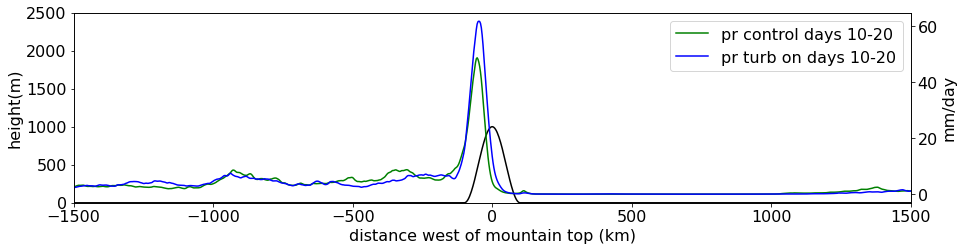

In [21]:
ax,ax2=plotsection(hrhgt,figsize=(15,3.5))

ax2.plot(hrdist,hrchannelprecip[60:80].mean(['Time','south_north']),color='green',label='pr control days 10-20')
ax2.plot(hrdist,tbchannelprecip[60:80].mean(['Time','south_north']),color='b',label='pr turb on days 10-20')

ax2.set_ylabel("mm/day")
ax2.legend()
ax.set_xlim(-1500,1500)
ax.set_ylim(0.,2500.)
#ax2.set_ylim(-3.5,3.5)

In [24]:
%time hrwmean_s = hrchannel.W[40:80].mean(['Time','south_north']).load()

CPU times: user 1.64 s, sys: 3.71 s, total: 5.35 s
Wall time: 7.28 s


In [25]:
%time tbwmean_s = tbchannel.W[40:80].mean(['Time','south_north']).load()

CPU times: user 1.58 s, sys: 2.57 s, total: 4.15 s
Wall time: 5.14 s


Text(0.5, 1.0, 'Turbulence on minus off - RMSE = 0.01460 m/s')

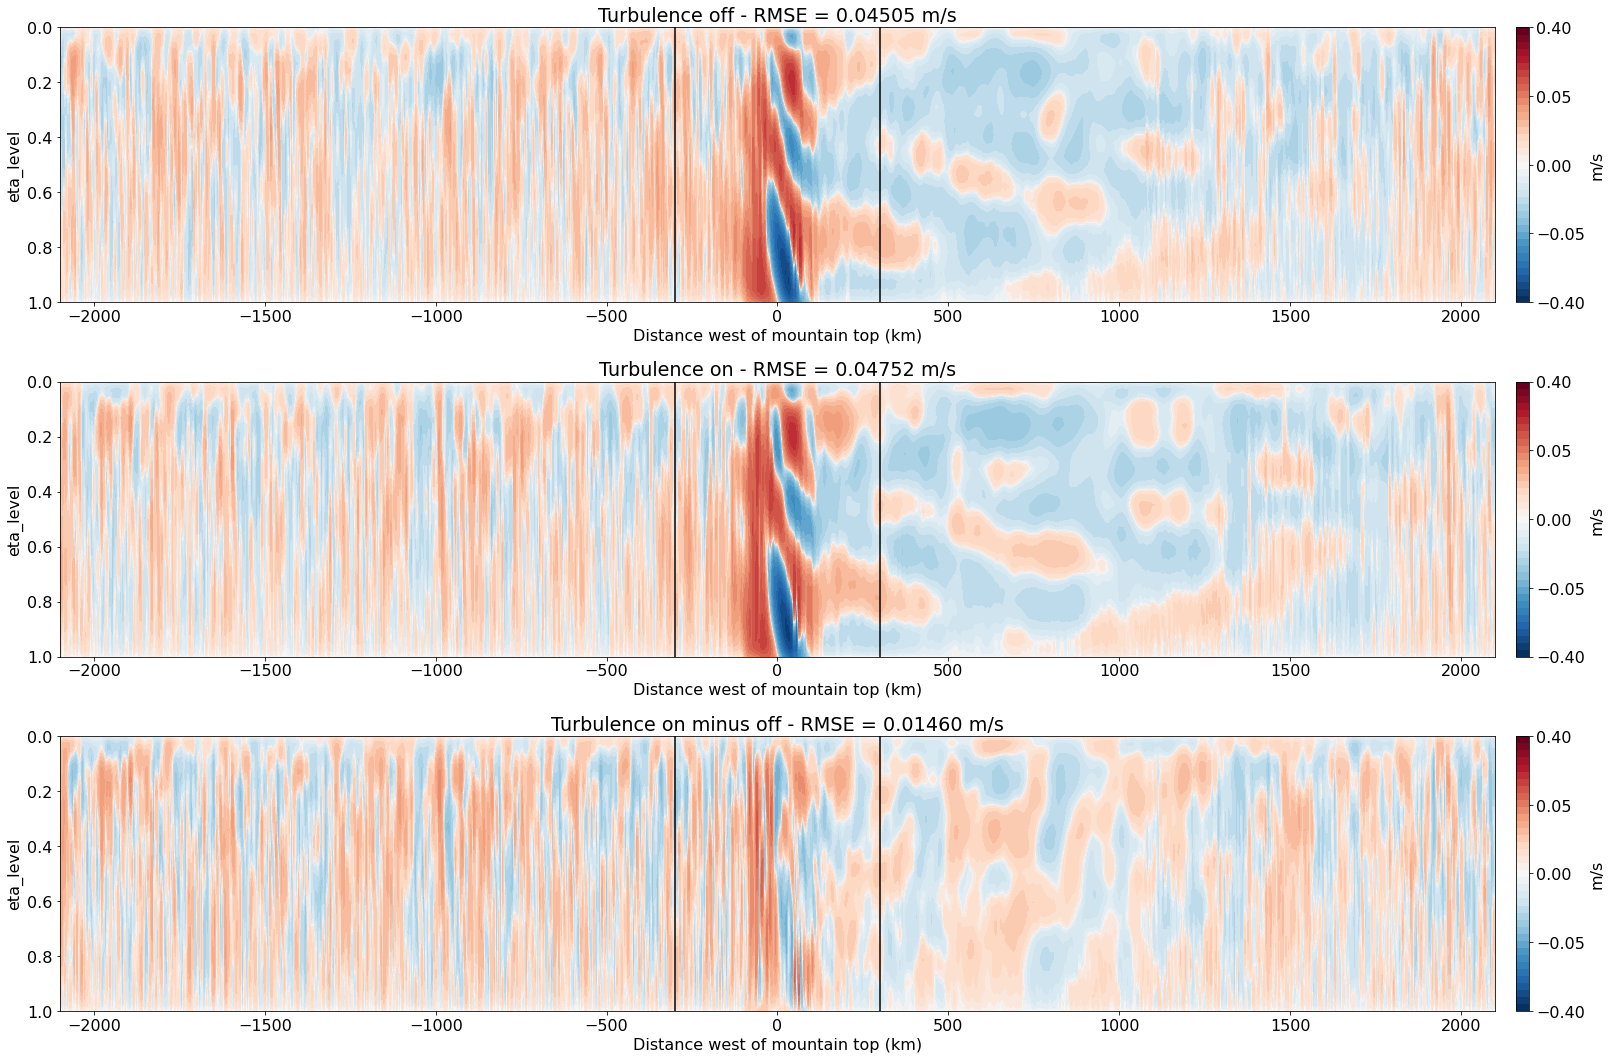

In [66]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(3,1,figsize=(25,15))
wlevs=levs(0.4,3)
wticks=[-.5,-.4,-.05,0.,.05,.4,.5]

change_coords_eta(hrchannel,hrwmean_s,staggered=True).plot.contourf(ax=ax[0], yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)
change_coords_eta(tbchannel,tbwmean_s,staggered=True).plot.contourf(ax=ax[1], yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'m/s','pad':.012})
change_coords_eta(hrchannel,tbwmean_s-hrwmean_s,staggered=True).plot.contourf(ax=ax[2], yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)


for a in ax:
    a.set_xlabel("Distance west of mountain top (km)")
    a.set_xlim(-2100,2100)
    a.axvline(-300,color='k')
    a.axvline(300,color='k')
    
fig.tight_layout()
ax[0].set_title("Turbulence off - RMSE = %.5f m/s"%np.sqrt((hrwmean_s[:,1535:1735]**2).mean()))
ax[1].set_title("Turbulence on - RMSE = %.5f m/s"%np.sqrt((tbwmean_s[:,1535:1735]**2).mean()))
ax[2].set_title("Turbulence on minus off - RMSE = %.5f m/s"%np.sqrt(((tbwmean_s-hrwmean_s)[:,1535:1735]**2).mean()))


In [109]:
def change_coords_sn(var):
    return var.assign_coords({'distance_ns':3*var.south_north}).swap_dims({'south_north':'distance_ns'})


In [174]:
t=40
hrw40 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.W[t,:,:,:],staggered=True)).sel(distance_from_mtn=slice(400,-400)).load()
qcw40 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.QCLOUD[t,:,:,:])).sel(distance_from_mtn=slice(400,-400)).load()
qrw40 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.QRAIN[t,:,:,:])).sel(distance_from_mtn=slice(400,-400)).load()
hrpr40 = change_coords_sn(change_coords_sfc(hrchannelprecip[t,:,:])).sel(distance_from_mtn=slice(400,-400)).load()

In [170]:
hrw611 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.W[611,:,:,:],staggered=True)).sel(distance_from_mtn=slice(400,-400)).load()
qcw611 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.QCLOUD[611,:,:,:])).sel(distance_from_mtn=slice(400,-400)).load()
qrw611 = change_coords_sn(change_coords_eta(hrchannel,hrchannel.QRAIN[611,:,:,:])).sel(distance_from_mtn=slice(400,-400)).load()
hrpr611 = change_coords_sn(change_coords_sfc(hrchannelprecip[611,:,:])).sel(distance_from_mtn=slice(400,-400)).load()

49798.765625


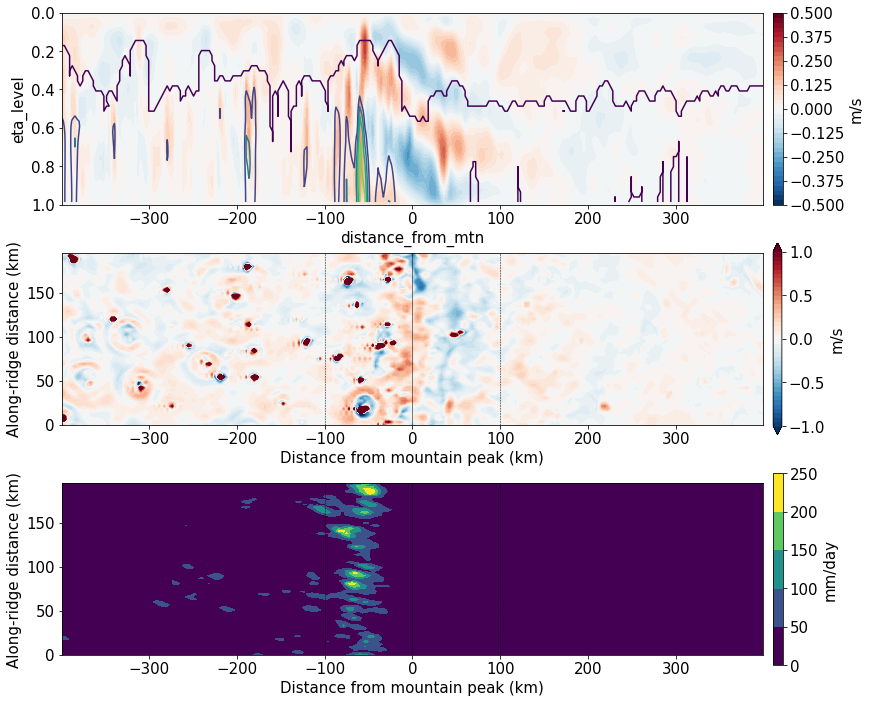

In [175]:
matplotlib.rcParams.update({'font.size': 15})
fig,(ax0,ax,ax2) = plt.subplots(3,1,figsize=(15,12))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)

wscale=.5
wlevs2=np.linspace(-wscale,wscale,41)

hrw40.mean('distance_ns').plot.contourf(ax=ax0,yincrease=False,levels=wlevs2,cbar_kwargs={'label':'m/s','pad':.012})
#qcw40.mean('distance_ns').plot.contour(ax=ax0,yincrease=False,**{'levels':[1e-5,5e-5],'colors':['gray','k']})
qrw40.mean('distance_ns').plot.contour(ax=ax0,yincrease=False)


lev=21;print(float(hrchannel.PB[0,lev,0,0].load()))
hrw40[lev].plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':'m/s','pad':.012})
hrpr40.plot.contourf(ax=ax2,cbar_kwargs={'label':'mm/day','pad':.012})

for a in ax,ax2:
    a.axvline(   0.,color='k',linewidth=0.5)
    a.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
    a.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
    a.set_aspect("equal")
    a.set_xlabel("Distance from mountain peak (km)")
    a.set_ylabel("Along-ridge distance (km)")
    a.set_title("")

63808.4140625


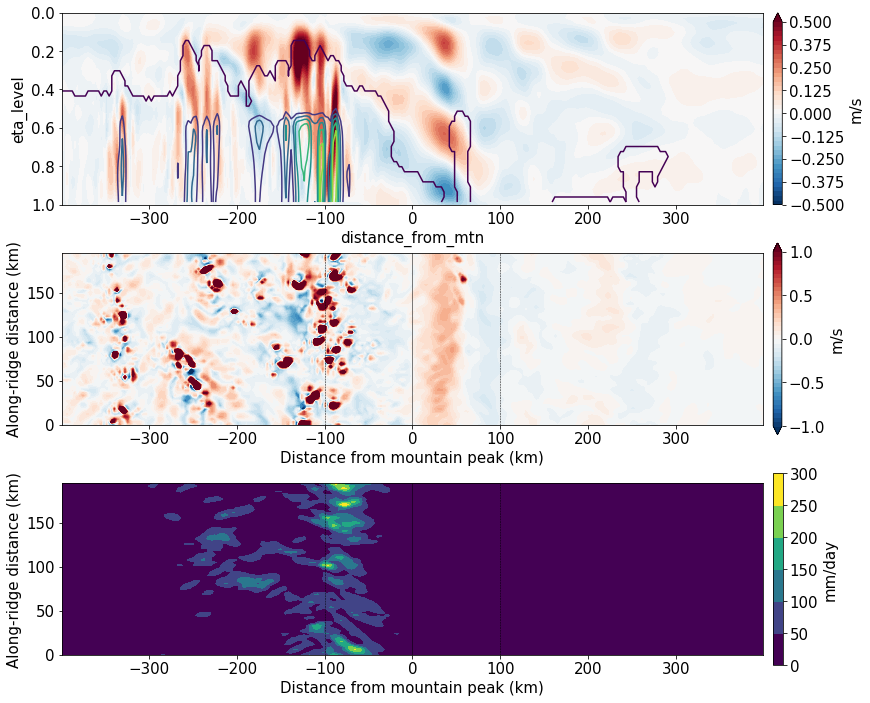

In [171]:
matplotlib.rcParams.update({'font.size': 15})
fig,(ax0,ax,ax2) = plt.subplots(3,1,figsize=(15,12))

hrw611.mean('distance_ns').plot.contourf(ax=ax0,yincrease=False,levels=wlevs2,cbar_kwargs={'label':'m/s','pad':.012})
qrw611.mean('distance_ns').plot.contour(ax=ax0,yincrease=False)


lev=15;print(float(hrchannel.PB[0,lev,0,0].load()))
hrw611[lev].plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':'m/s','pad':.012})
hrpr611.plot.contourf(ax=ax2,cbar_kwargs={'label':'mm/day','pad':.012})

for a in ax,ax2:
    a.axvline(   0.,color='k',linewidth=0.5)
    a.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
    a.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
    a.set_aspect("equal")
    a.set_xlabel("Distance from mountain peak (km)")
    a.set_ylabel("Along-ridge distance (km)")
    a.set_title("")

In [43]:
%%time
hrtemp = (hrchannel.T[40:80]+300)*((hrchannel.PB[40:80]+hrchannel.P[40:80])/1e5)**0.286
hrt_s = change_coords_eta(hrchannel,hrtemp.mean(['Time','south_north']).load())

tbtemp = (tbchannel.T[40:80]+300)*((tbchannel.PB[40:80]+tbchannel.P[40:80])/1e5)**0.286
tbt_s = change_coords_eta(tbchannel,tbtemp.mean(['Time','south_north']).load())

CPU times: user 37.6 s, sys: 19.3 s, total: 56.9 s
Wall time: 57.1 s


In [42]:
%%time
hrq_s = change_coords_eta(hrchannel,hrchannel.QVAPOR[40:80].mean(['Time','south_north']).load())
tbq_s = change_coords_eta(tbchannel,tbchannel.QVAPOR[40:80].mean(['Time','south_north']).load())

CPU times: user 8.73 s, sys: 11.8 s, total: 20.5 s
Wall time: 15.1 s


 CAPE = 2680.9 J/kg
 CAPE = 2918.3 J/kg


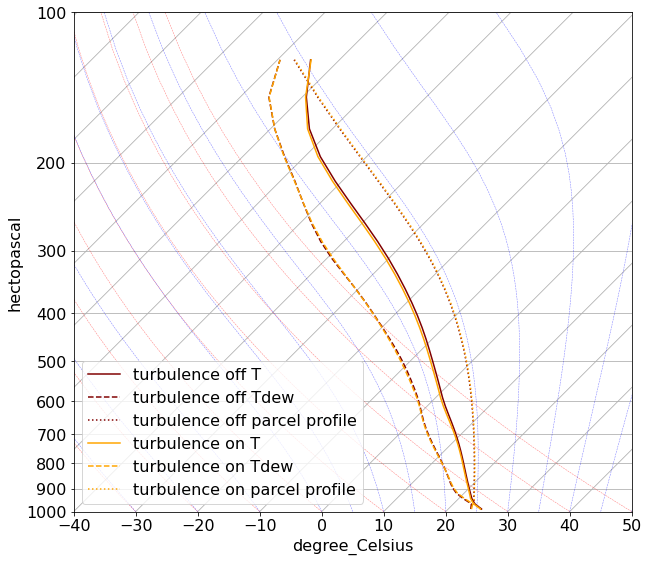

In [50]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, rotation=45)

plot_skewt(hrt_s[:,2000:3000].mean('distance_from_mtn'),hrq_s[:,2000:3000].mean('distance_from_mtn'),hrq_s.sel(distance_from_mtn=-3000,method='nearest').pressure,skew,"maroon",'turbulence off')
plot_skewt(tbt_s[:,2000:3000].mean('distance_from_mtn'),tbq_s[:,2000:3000].mean('distance_from_mtn'),tbq_s.sel(distance_from_mtn=-3000,method='nearest').pressure,skew,"orange",'turbulence on')



In [100]:
Theta = change_coords_etav(hrchannel,hrchannel.T[-100:,:,:,2000:3000].mean(['Time','south_north','west_east']).load())

In [101]:
Z = np.array(hrchannel.PHB[-1,:,0,0]+hrchannel.PH[-100:,:,:,2000:3000].mean(['Time','south_north','west_east']))/9.81

In [102]:
full_eta=hrchannel.ZNW.isel(Time=-1)
eta=hrchannel.ZNU.isel(Time=-1).load()
deta=np.diff(full_eta)
detadz = xr.DataArray(deta/np.diff(Z),coords={'eta_level':np.array(eta)},dims=['eta_level'])

In [103]:
Nsq = 9.81/(300+Theta)*Theta.differentiate('eta_level')*detadz

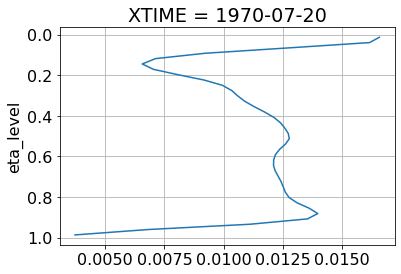

In [104]:
np.sqrt(Nsq).plot(y='eta_level',yincrease=False)
plt.grid()

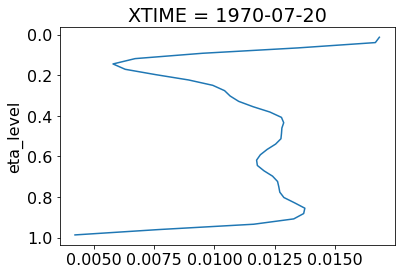

In [94]:
np.sqrt(Nsq).plot(y='eta_level',yincrease=False)

In [179]:
lev=-5;print(float(hrchannel.PB[0,lev,0,0].load()))

21779.47265625
